In [4]:
import numpy as np
import random
import json
import datetime
# import wikipedia
# import pywhatkit
import pyttsx3
from gtts import gTTS
import speech_recognition as sr
import nltk
from nltk.stem.porter import PorterStemmer
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

In [5]:
# !pip install pyaudio

In [6]:
def Say(Text):
    # obj = gTTS(text=Text,slow=False,lang='hi')
    # obj.stream()
    engine = pyttsx3.init("sapi5")
    voices = engine.getProperty('voices')
    engine.setProperty('voices',voices[0].id)
    engine.setProperty('rate',175)
    engine.setProperty("languages",'hi-In')
    print(" ")
    print(f"Bot: {Text}")
    engine.say(text=Text)
    engine.runAndWait()
    print(" ")
# Say("इंग्लिश")

In [7]:
def Listen():
    r = sr.Recognizer()
    
    with sr.Microphone() as source:
        print("Listening...")
        r.pause_threshold = 1
        audio = r.listen(source,0,3)
    
    try:
        print("Wait...")
        query = r.recognize_google(audio,language='hi-In')
        print(f"Me: {query}")
    except:
        return ""
    
    query = str(query)
    return query.lower()
# Listen()


In [8]:
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(NeuralNet,self).__init__()
        self.l1 = nn.Linear(input_size,hidden_size)
        self.l2 = nn.Linear(hidden_size,hidden_size)
        self.l3 = nn.Linear(hidden_size,num_classes)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

In [9]:
Stemmer = PorterStemmer()

def tokenize(sentence):
    return nltk.word_tokenize(sentence)

def stem(word):
    return Stemmer.stem(word.lower())

def bag_of_words(tokenized_sentence,words):
    sentence_word = [stem(word) for word in tokenized_sentence]
    bag = np.zeros(len(words),dtype=np.float32)
    
    for idx, w in enumerate(words):
        if w in sentence_word:
            bag[idx] = 1
    return bag

In [25]:
with open('Hindi101.json','r',encoding="utf8") as f:
    intents = json.load(f)
    
all_words = []
tags = []
xy = []

for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    
    for pattern in intent['patterns']:
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w,tag))

ignore_words = [',','?','/','!','.']
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

x_train = []
y_train = []

for(pattern_sentence,tag) in xy:
    bag = bag_of_words(pattern_sentence,all_words)
    x_train.append(bag)
    
    label = tags.index(tag)
    y_train.append(label)
    
x_train = np.array(x_train)
y_train = np.array(y_train)

num_epochs = 500
batch_size = 8
learning_rate = 0.0001
input_size = len(x_train[0])
hidden_size = 8
output_size = len(tags)

class ChatDataSet(Dataset):
    
    def __init__(self):
        self.n_samples = len(x_train)
        self.x_data = x_train
        self.y_data = y_train
    
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    
    def __len__(self):
        return self.n_samples
    
dataset=ChatDataSet()

train_loader = DataLoader (
                        dataset = dataset,
                        batch_size = batch_size,
                        shuffle = True,
                        num_workers = 0 )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(input_size,hidden_size,output_size).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(num_epochs):
    for(words,labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        outputs = model(words)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss:{loss.item():.4f}")
        
print(f"Final Loss: {loss.item():.4f}")
data = {
    "model_state":model.state_dict(),
    "input_size":input_size,
    "hidden_size":hidden_size,
    "output_size":output_size,
    "all_words":all_words,
    "tags":tags
}

FILE = "TrainData.pth"
torch.save(data,FILE)

Epoch [50/500], Loss:4.0983
Epoch [100/500], Loss:3.5804
Epoch [150/500], Loss:3.6340
Epoch [200/500], Loss:3.1774
Epoch [250/500], Loss:2.7995
Epoch [300/500], Loss:3.4470
Epoch [350/500], Loss:1.4827
Epoch [400/500], Loss:3.4345
Epoch [450/500], Loss:2.8416
Epoch [500/500], Loss:2.8862
Final Loss: 2.8862


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with open('Hindi101.json','r',encoding="utf8") as json_data:
    intents = json.load(json_data)
    
FILE = "TrainData.pth"
data = torch.load(FILE)

input_size = data['input_size']
hidden_size = data['hidden_size']
output_size = data['output_size']
all_words = data['all_words']
tags = data['tags']
model_state = data['model_state']

model = NeuralNet(input_size,hidden_size,output_size).to(device)
model.load_state_dict(model_state)
model.eval()


def Main():
    sentence = Listen()
    
    if sentence == 'bye':
        exit()
        
    sentence = tokenize(sentence)
    X = bag_of_words(sentence,all_words)
    X = X.reshape(1,X.shape[0])
    X = torch.from_numpy(X).to(device)
    
    output = model(X)
    
    _,predicted = torch.max(output,dim=1)
    tag = tags[predicted.item()]
    
    probs = torch.softmax(output,dim=1)
    prob = probs[0][predicted.item()]
    
    if prob.item()>0.75:
        for intent in intents['intents']:
            if tag == intent["tag"]:
                reply = random.choice(intent["responses"])
                Say(reply)
                break
                
queries = 10
while queries:
    Main()
    queries -= 1

Listening...
Wait...
 
Bot: कृपया अपना प्रश्न विस्तृत करें
 
Listening...
Wait...
 
Bot: आपके प्रश्न को नहीं समझ सकता
 
Listening...


KeyboardInterrupt: 

In [28]:
with open('Hindi101.json','r',encoding="utf8") as f:
    intents = json.load(f)
    
all_words = []
tags = []
xy = []

for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    
    for pattern in intent['patterns']:
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w,tag))

ignore_words = [',','?','/','!','.']
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

x_train = []
y_train = []

for(pattern_sentence,tag) in xy:
    bag = bag_of_words(pattern_sentence,all_words)
    x_train.append(bag)
    
    label = tags.index(tag)
    y_train.append(label)
    
x_train = np.array(x_train)
y_train = np.array(y_train)

num_epochs = 500
batch_size = 8
learning_rate = 0.0001
input_size = len(x_train[0])
hidden_size = 8
output_size = len(tags)

class ChatDataSet(Dataset):
    
    def __init__(self):
        self.n_samples = len(x_train)
        self.x_data = x_train
        self.y_data = y_train
    
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    
    def __len__(self):
        return self.n_samples
    
dataset=ChatDataSet()

train_loader = DataLoader (
                        dataset = dataset,
                        batch_size = batch_size,
                        shuffle = True,
                        num_workers = 0 )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = NeuralNet(input_size,hidden_size,output_size).to(device=device)
# criterion = nn.CrossEntropyLoss()
import matplotlib.pyplot as plt
import torch.optim as optim

# Define your model and loss function
model = nn.Sequential(
    nn.Linear(10, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)
criterion = nn.MSELoss()

# Initialize lists to store the final loss values for each optimizer
adam_losses = []
sgd_losses = []
rmsprop_losses = []

# Define the hyperparameter values to test
num_epochs = [10, 50, 100]
batch_sizes = [8, 16, 32]
learning_rates = [0.1, 0.01, 0.001]

# Loop over the different hyperparameter values
for epochs in num_epochs:
    for batch_size in batch_sizes:
        for lr in learning_rates:
            
            # Loop over the different optimizers
            for opt_name in ['Adam', 'SGD', 'RMSprop']:
                
                # Initialize the optimizer with the current hyperparameter values and optimizer
                if opt_name == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                elif opt_name == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=lr)
                else:
                    optimizer = optim.RMSprop(model.parameters(), lr=lr)
                
                # Train your model for the specified number of epochs with the current hyperparameter values and optimizer
                # (insert your training code here)
                for(words,labels) in train_loader:
                    words = words.to(device)
                    labels = labels.to(dtype=torch.long).to(device)
                    outputs = model(words)
                    loss = criterion(outputs,labels)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                if (epoch+1) % 50 == 0:
                    print(f"Epoch [{epoch+1}/{num_epochs}], Loss:{loss.item():.4f}")
                    
                final_loss= loss.item()
                
                # Calculate the final loss for the current hyperparameter values and optimizer and store it in the corresponding list
                # (insert your code to calculate the final loss here)
                if opt_name == 'Adam':
                    adam_losses.append(final_loss)
                elif opt_name == 'SGD':
                    sgd_losses.append(final_loss)
                else:
                    rmsprop_losses.append(final_loss)

# Plot the final loss values for each optimizer as a function of the hyperparameters you varied
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title('Adam')
plt.plot(adam_losses)
plt.subplot(132)
plt.title('SGD')
plt.plot(sgd_losses)
plt.subplot(133)
plt.title('RMSprop')
plt.plot(rmsprop_losses)
plt.show()
# optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# for epoch in range(num_epochs):
#     for(words,labels) in train_loader:
#         words = words.to(device)
#         labels = labels.to(dtype=torch.long).to(device)
#         outputs = model(words)
#         loss = criterion(outputs,labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#     if (epoch+1) % 50 == 0:
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss:{loss.item():.4f}")
        
# print(f"Final Loss: {loss.item():.4f}")
# data = {
#     "model_state":model.state_dict(),
#     "input_size":input_size,
#     "hidden_size":hidden_size,
#     "output_size":output_size,
#     "all_words":all_words,
#     "tags":tags
# }

# FILE = "TrainData.pth"
# torch.save(data,FILE)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x269 and 10x5)

In [31]:
import itertools

# Define hyperparameters
num_epochs_list = [100, 500, 1000, 2000]
batch_size_list = [4, 8, 16, 32]
learning_rate_list = [0.0001, 0.0002, 0.0005, 0.001, 0.01]
optimizer_list = [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop]

# Loop through all possible hyperparameter combinations
results = []
for num_epochs, batch_size, learning_rate, optimizer in itertools.product(num_epochs_list, batch_size_list, learning_rate_list, optimizer_list):
    print(f"Training model with num_epochs={num_epochs}, batch_size={batch_size}, learning_rate={learning_rate}, optimizer={optimizer}...")
    
    # Train model
    dataset = ChatDataSet()
    train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = NeuralNet(input_size, hidden_size, output_size).to(device=device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for words, labels in train_loader:
            words = words.to(device)
            labels = labels.to(dtype=torch.long).to(device)
            outputs = model(words)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    final_loss = loss.item()
    results.append((num_epochs, batch_size, learning_rate, optimizer, final_loss))
    print(f"Final Loss: {final_loss:.4f}")

# Plot graph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results, columns=["num_epochs", "batch_size", "learning_rate", "optimizer", "final_loss"])
sns.relplot(data=df, x="learning_rate", y="final_loss", col="num_epochs", row="batch_size", hue="optimizer")
plt.show()


Training model with num_epochs=100, batch_size=4, learning_rate=0.0001, optimizer=<class 'torch.optim.adam.Adam'>...
Final Loss: 3.0551
Training model with num_epochs=100, batch_size=4, learning_rate=0.0001, optimizer=<class 'torch.optim.sgd.SGD'>...
Final Loss: 3.5619
Training model with num_epochs=100, batch_size=4, learning_rate=0.0001, optimizer=<class 'torch.optim.rmsprop.RMSprop'>...
Final Loss: 3.5690
Training model with num_epochs=100, batch_size=4, learning_rate=0.0002, optimizer=<class 'torch.optim.adam.Adam'>...
Final Loss: 2.5833
Training model with num_epochs=100, batch_size=4, learning_rate=0.0002, optimizer=<class 'torch.optim.sgd.SGD'>...
Final Loss: 4.0174
Training model with num_epochs=100, batch_size=4, learning_rate=0.0002, optimizer=<class 'torch.optim.rmsprop.RMSprop'>...
Final Loss: 2.4058
Training model with num_epochs=100, batch_size=4, learning_rate=0.0005, optimizer=<class 'torch.optim.adam.Adam'>...
Final Loss: 1.1250
Training model with num_epochs=100, batc

Training model with num_epochs=100, batch_size=4, learning_rate=0.0001, optimizer=<class 'torch.optim.adam.Adam'>...
Final Loss: 3.0625
Training model with num_epochs=100, batch_size=4, learning_rate=0.001, optimizer=<class 'torch.optim.adam.Adam'>...
Final Loss: 0.1420
Training model with num_epochs=100, batch_size=4, learning_rate=0.01, optimizer=<class 'torch.optim.adam.Adam'>...
Final Loss: 0.0000
Training model with num_epochs=100, batch_size=8, learning_rate=0.0001, optimizer=<class 'torch.optim.adam.Adam'>...
Final Loss: 3.9869
Training model with num_epochs=100, batch_size=8, learning_rate=0.001, optimizer=<class 'torch.optim.adam.Adam'>...
Final Loss: 0.0594
Training model with num_epochs=100, batch_size=8, learning_rate=0.01, optimizer=<class 'torch.optim.adam.Adam'>...
Final Loss: 0.0003
Training model with num_epochs=100, batch_size=16, learning_rate=0.0001, optimizer=<class 'torch.optim.adam.Adam'>...
Final Loss: 3.6783
Training model with num_epochs=100, batch_size=16, le

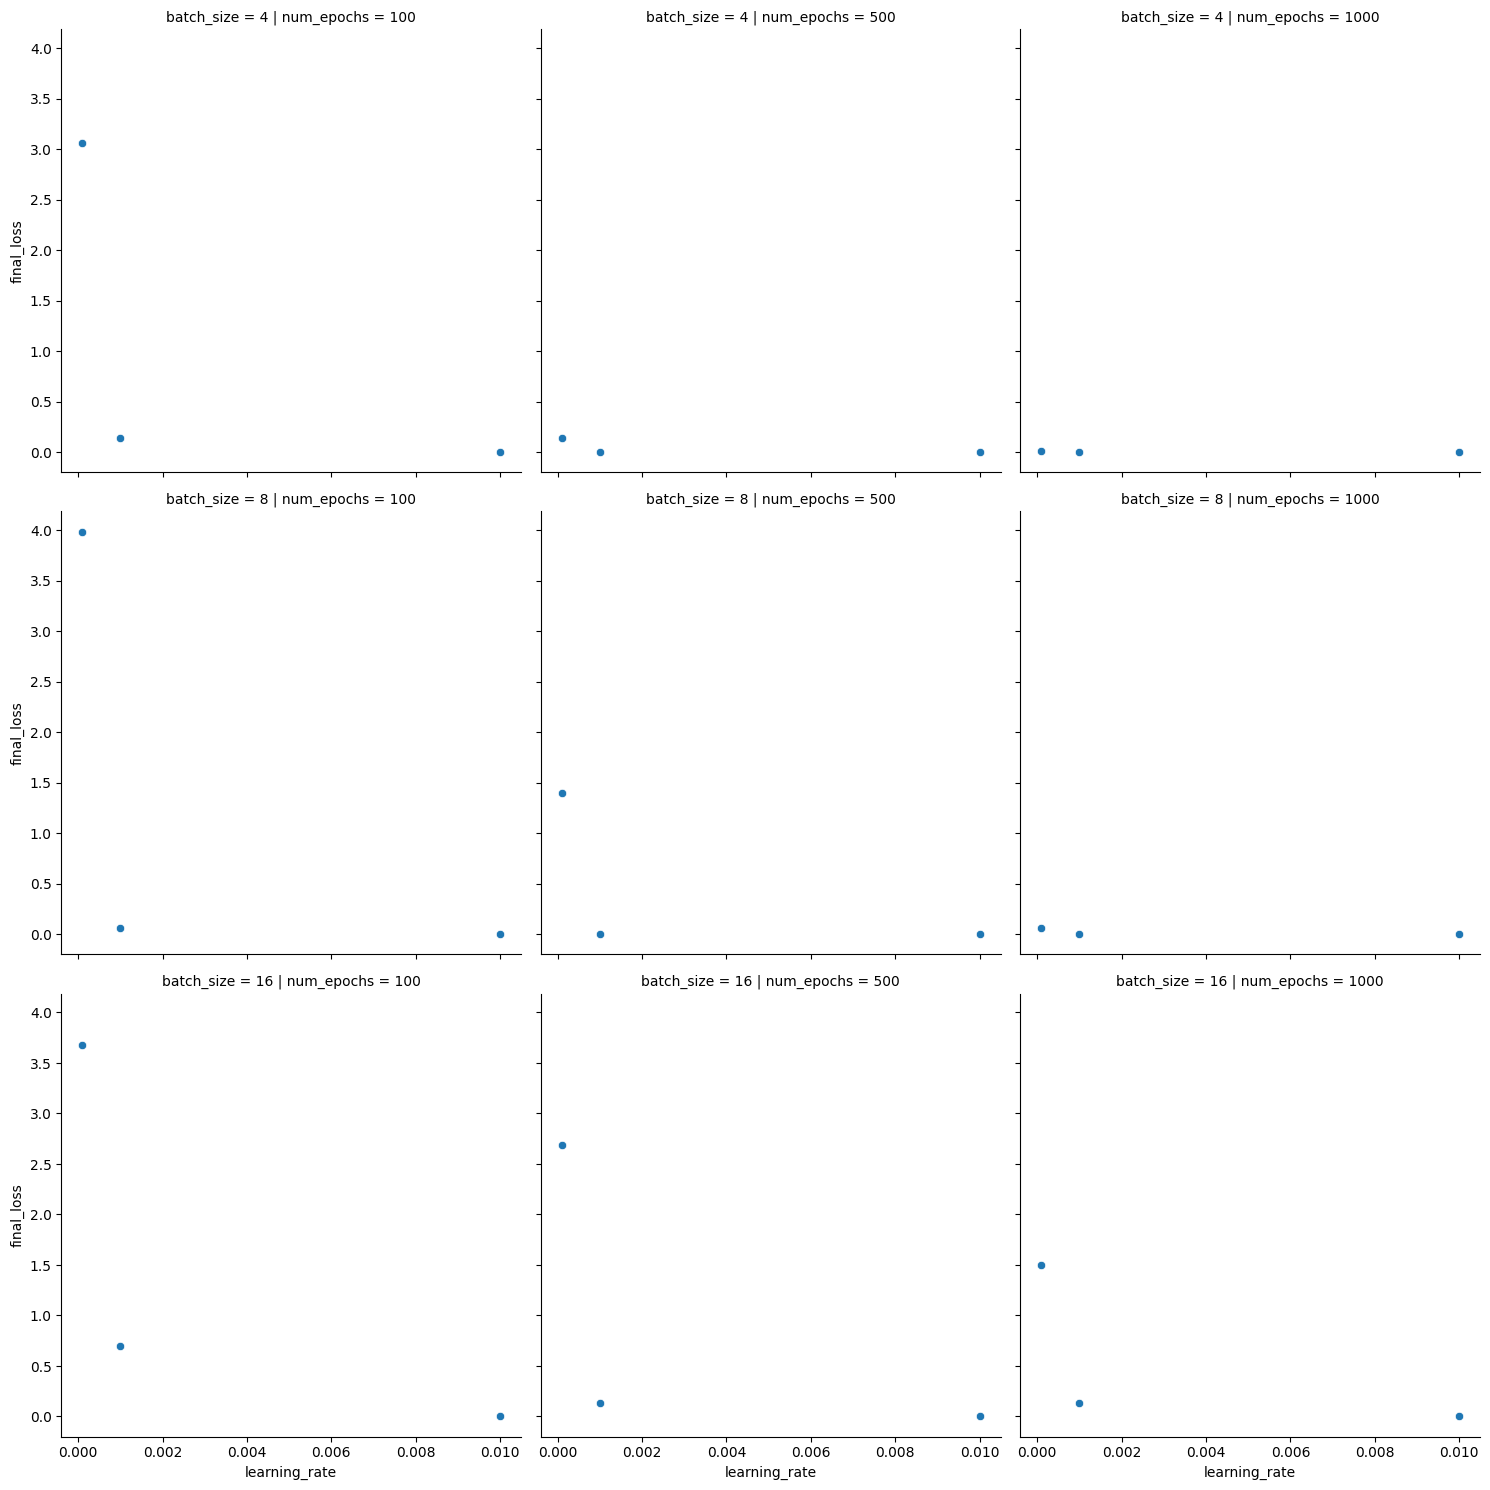

In [32]:
import itertools

# Define hyperparameters
num_epochs_list = [100, 500, 1000]
batch_size_list = [4, 8, 16]
learning_rate_list = [0.0001, 0.001, 0.01]
optimizer_list = [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop]

# Loop through all possible hyperparameter combinations
results = []
for num_epochs, batch_size, learning_rate in itertools.product(num_epochs_list, batch_size_list, learning_rate_list):
    optimizer = torch.optim.Adam
    print(f"Training model with num_epochs={num_epochs}, batch_size={batch_size}, learning_rate={learning_rate}, optimizer={optimizer}...")
    
    # Train model
    dataset = ChatDataSet()
    train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = NeuralNet(input_size, hidden_size, output_size).to(device=device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for words, labels in train_loader:
            words = words.to(device)
            labels = labels.to(dtype=torch.long).to(device)
            outputs = model(words)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    final_loss = loss.item()
    results.append((num_epochs, batch_size, learning_rate, final_loss))
    print(f"Final Loss: {final_loss:.4f}")

# Plot graph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results, columns=["num_epochs", "batch_size", "learning_rate", "final_loss"])
sns.relplot(data=df, x="learning_rate", y="final_loss", col="num_epochs", row="batch_size")
plt.show()

Training model with num_epochs=100, batch_size=4, learning_rate=0.0001, optimizer=<class 'torch.optim.sgd.SGD'>...
Final Loss: 3.5755
Training model with num_epochs=100, batch_size=4, learning_rate=0.001, optimizer=<class 'torch.optim.sgd.SGD'>...
Final Loss: 4.0217
Training model with num_epochs=100, batch_size=4, learning_rate=0.01, optimizer=<class 'torch.optim.sgd.SGD'>...
Final Loss: 3.8863
Training model with num_epochs=100, batch_size=8, learning_rate=0.0001, optimizer=<class 'torch.optim.sgd.SGD'>...
Final Loss: 3.7623
Training model with num_epochs=100, batch_size=8, learning_rate=0.001, optimizer=<class 'torch.optim.sgd.SGD'>...
Final Loss: 3.5340
Training model with num_epochs=100, batch_size=8, learning_rate=0.01, optimizer=<class 'torch.optim.sgd.SGD'>...
Final Loss: 3.7073
Training model with num_epochs=100, batch_size=16, learning_rate=0.0001, optimizer=<class 'torch.optim.sgd.SGD'>...
Final Loss: 3.9025
Training model with num_epochs=100, batch_size=16, learning_rate=0.

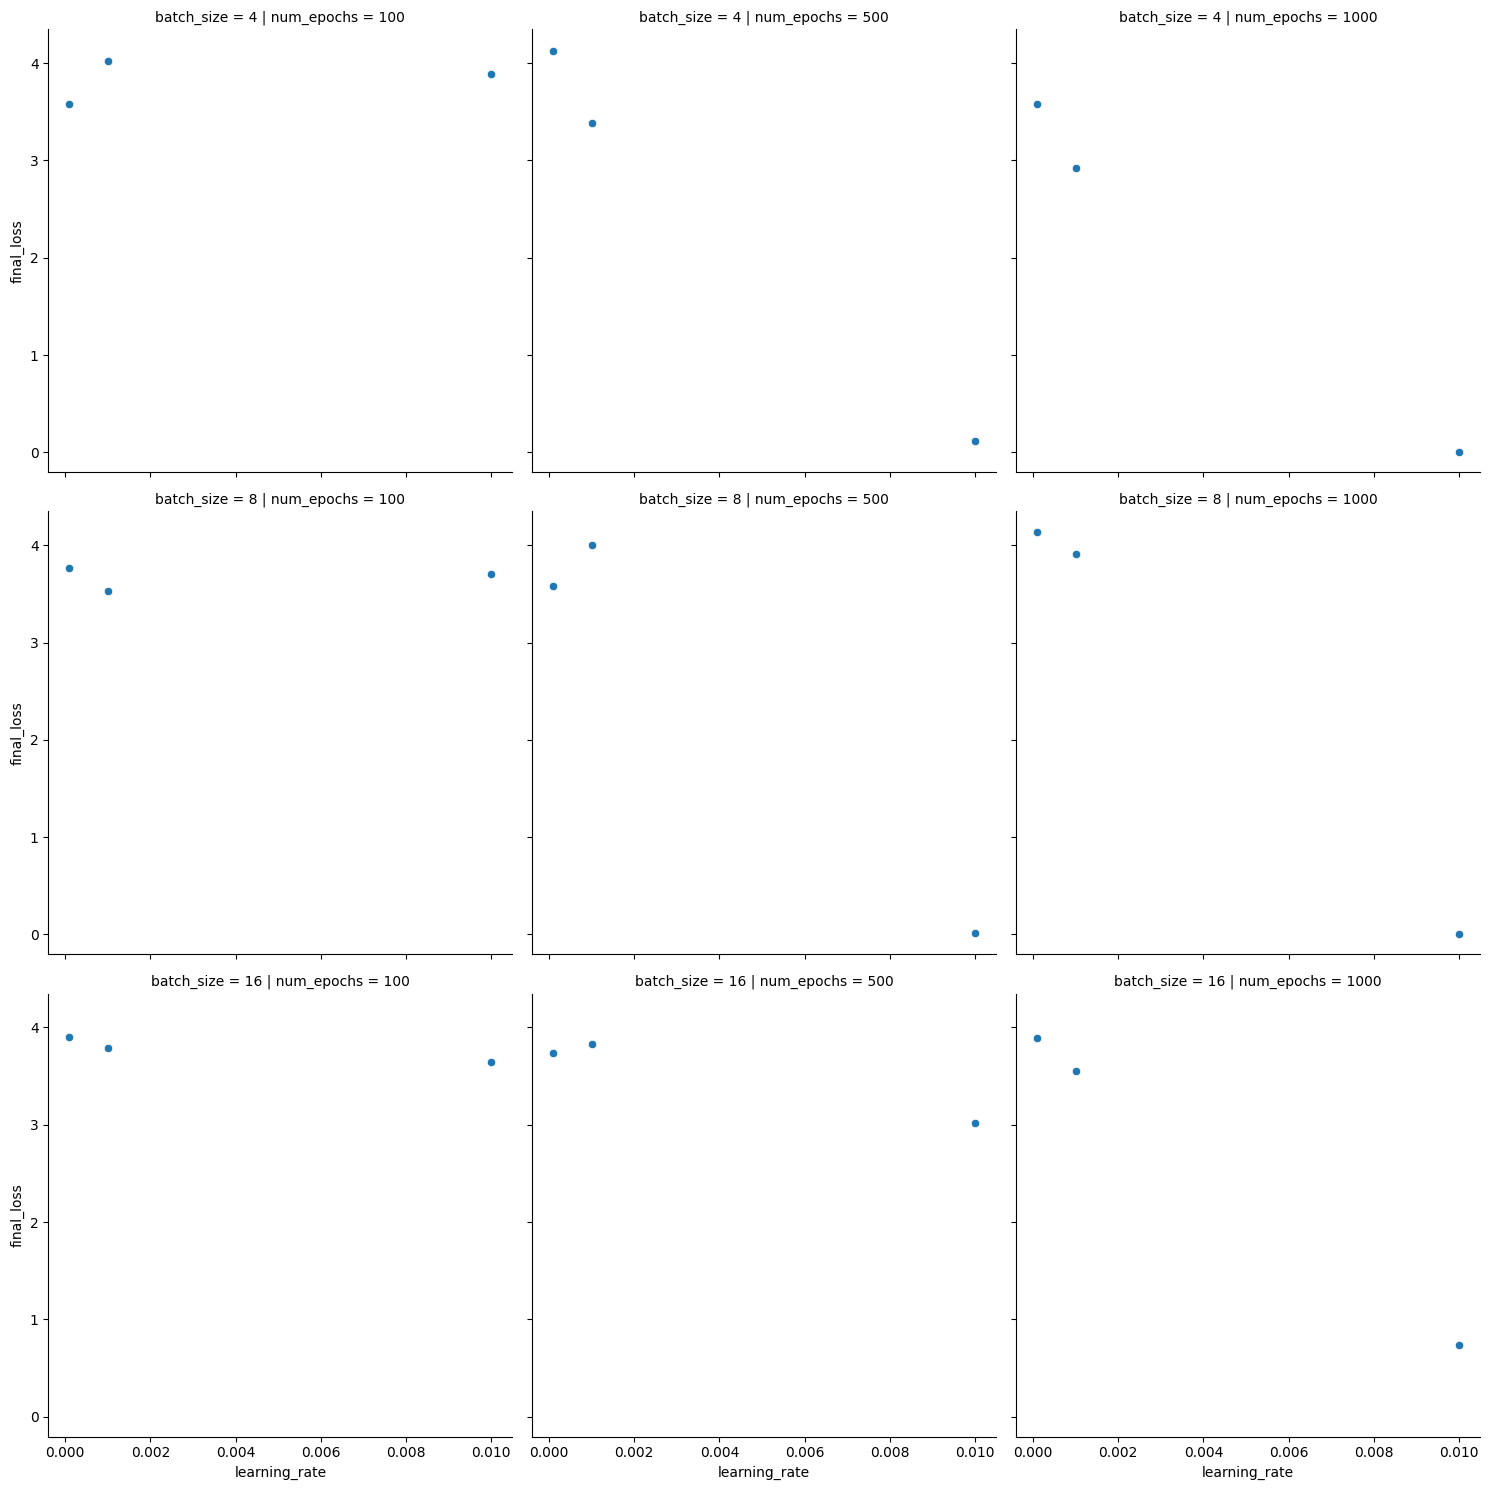

In [33]:
import itertools

# Define hyperparameters
num_epochs_list = [100, 500, 1000]
batch_size_list = [4, 8, 16]
learning_rate_list = [0.0001, 0.001, 0.01]
optimizer_list = [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop]

# Loop through all possible hyperparameter combinations
results = []
for num_epochs, batch_size, learning_rate in itertools.product(num_epochs_list, batch_size_list, learning_rate_list):
    optimizer = torch.optim.SGD
    print(f"Training model with num_epochs={num_epochs}, batch_size={batch_size}, learning_rate={learning_rate}, optimizer={optimizer}...")
    
    # Train model
    dataset = ChatDataSet()
    train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = NeuralNet(input_size, hidden_size, output_size).to(device=device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for words, labels in train_loader:
            words = words.to(device)
            labels = labels.to(dtype=torch.long).to(device)
            outputs = model(words)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    final_loss = loss.item()
    results.append((num_epochs, batch_size, learning_rate, final_loss))
    print(f"Final Loss: {final_loss:.4f}")

# Plot graph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results, columns=["num_epochs", "batch_size", "learning_rate", "final_loss"])
sns.relplot(data=df, x="learning_rate", y="final_loss", col="num_epochs", row="batch_size")
plt.show()

Training model with num_epochs=100, batch_size=4, learning_rate=0.0001, optimizer=<class 'torch.optim.rmsprop.RMSprop'>...
Final Loss: 3.3155
Training model with num_epochs=100, batch_size=4, learning_rate=0.001, optimizer=<class 'torch.optim.rmsprop.RMSprop'>...
Final Loss: 0.4079
Training model with num_epochs=100, batch_size=4, learning_rate=0.01, optimizer=<class 'torch.optim.rmsprop.RMSprop'>...
Final Loss: 0.0000
Training model with num_epochs=100, batch_size=8, learning_rate=0.0001, optimizer=<class 'torch.optim.rmsprop.RMSprop'>...
Final Loss: 3.6258
Training model with num_epochs=100, batch_size=8, learning_rate=0.001, optimizer=<class 'torch.optim.rmsprop.RMSprop'>...
Final Loss: 0.5858
Training model with num_epochs=100, batch_size=8, learning_rate=0.01, optimizer=<class 'torch.optim.rmsprop.RMSprop'>...
Final Loss: 0.0000
Training model with num_epochs=100, batch_size=16, learning_rate=0.0001, optimizer=<class 'torch.optim.rmsprop.RMSprop'>...
Final Loss: 3.6026
Training mo

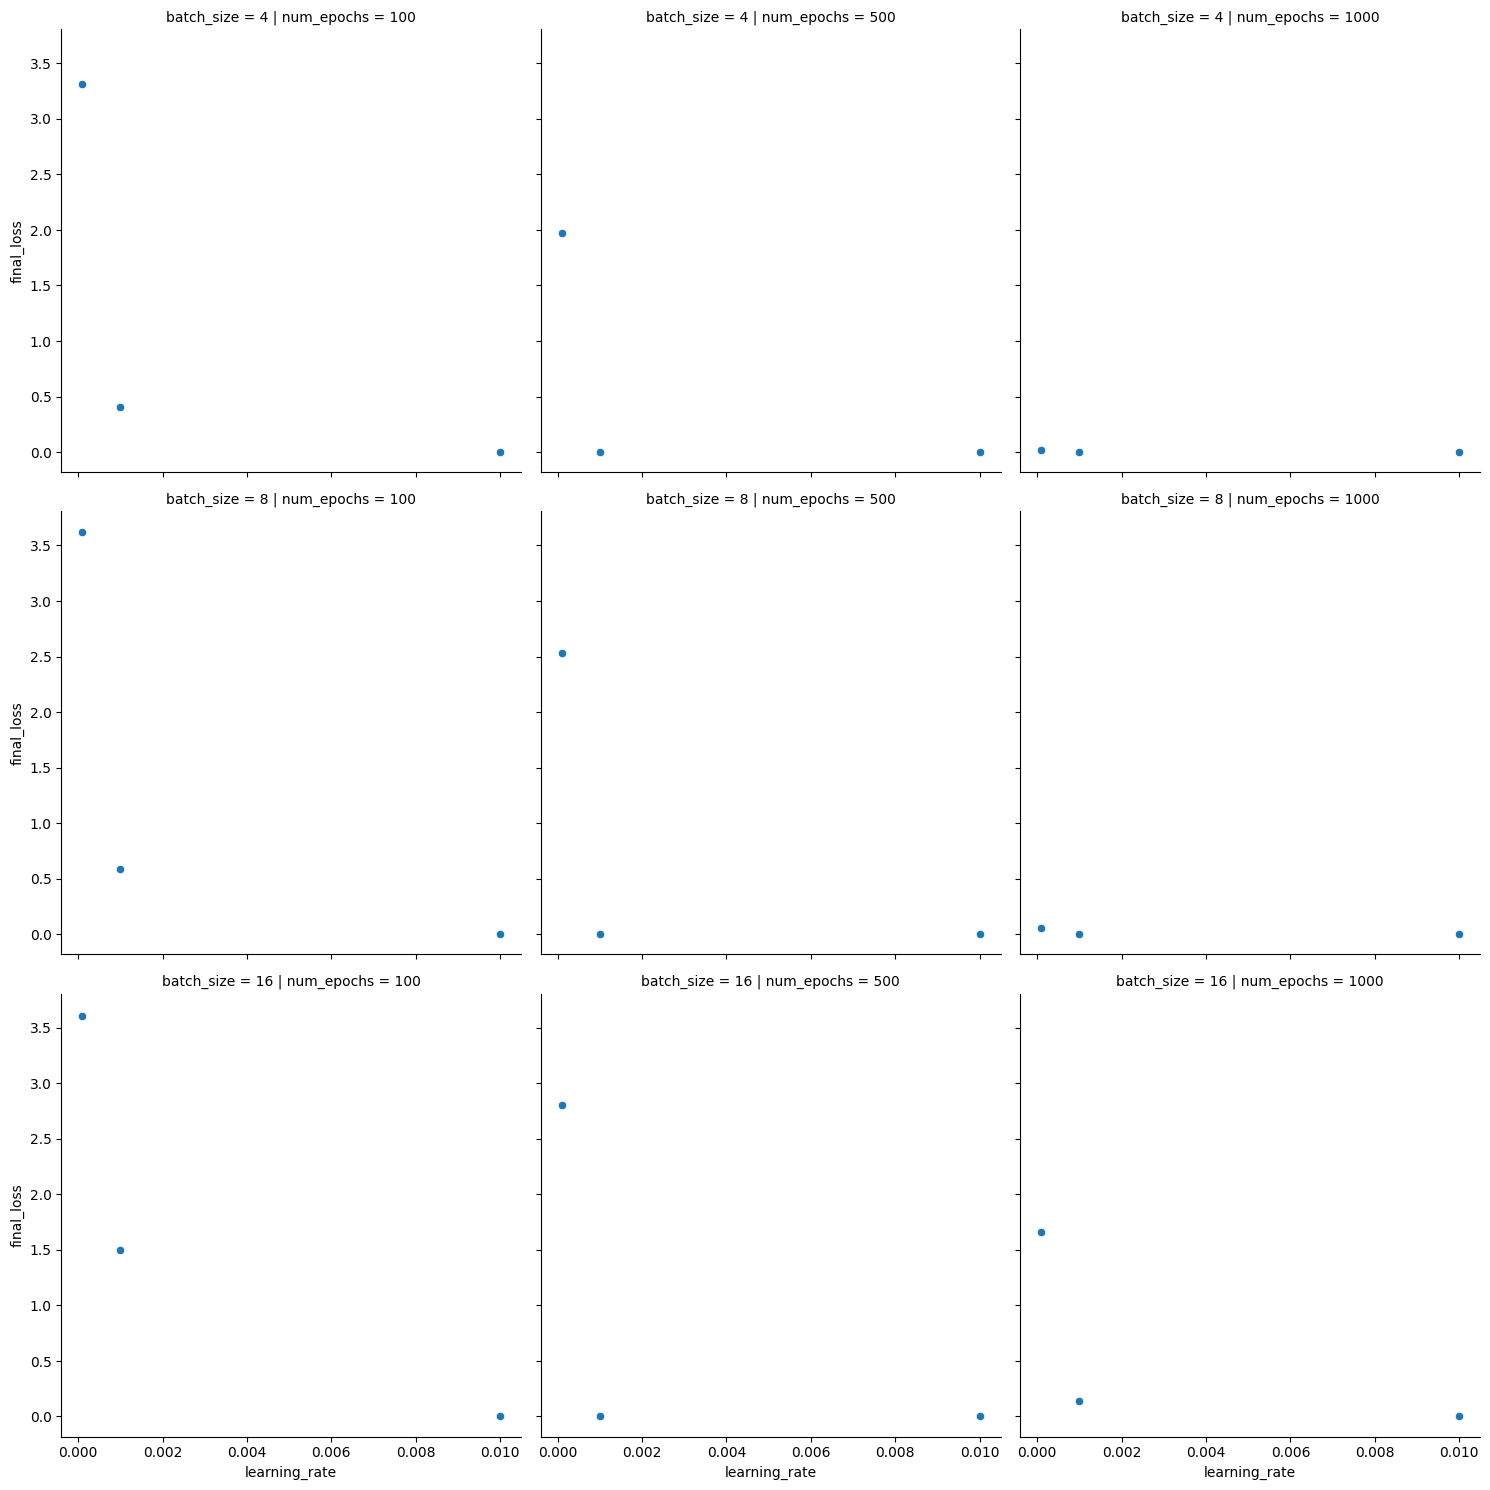

In [34]:
import itertools

# Define hyperparameters
num_epochs_list = [100, 500, 1000]
batch_size_list = [4, 8, 16]
learning_rate_list = [0.0001, 0.001, 0.01]
optimizer_list = [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop]

# Loop through all possible hyperparameter combinations
results = []
for num_epochs, batch_size, learning_rate in itertools.product(num_epochs_list, batch_size_list, learning_rate_list):
    optimizer = torch.optim.RMSprop
    print(f"Training model with num_epochs={num_epochs}, batch_size={batch_size}, learning_rate={learning_rate}, optimizer={optimizer}...")
    
    # Train model
    dataset = ChatDataSet()
    train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = NeuralNet(input_size, hidden_size, output_size).to(device=device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for words, labels in train_loader:
            words = words.to(device)
            labels = labels.to(dtype=torch.long).to(device)
            outputs = model(words)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    final_loss = loss.item()
    results.append((num_epochs, batch_size, learning_rate, final_loss))
    print(f"Final Loss: {final_loss:.4f}")

# Plot graph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results, columns=["num_epochs", "batch_size", "learning_rate", "final_loss"])
sns.relplot(data=df, x="learning_rate", y="final_loss", col="num_epochs", row="batch_size")
plt.show()